<a href="https://colab.research.google.com/github/raamav/Sentiment-Analysis-UserReviews/blob/master/IMDB_Reviews_DeepLearning_(v2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB Reviews

**IMDB Reviews** is one of the best known datasets for sentiment analysis. It comprises a set of 50,000 highly polarized reviews of movies which are tagged with *positive* and *negative* sentiment labels.

The 50,000 reviews are categorized into training and test sets (25,000 reviews each). These reviews are full-length and some of them are several paragraphs long.

I've worked on this dataset previously and have got a validation accuracy of 80%.

**In this attempt, the objective is to get an accuracy of 85% or better.**

In [67]:
# STANDARD IMPORTS

import tensorflow as tf
from tensorflow import keras
import numpy as np


tf.__version__


'2.2.0-rc2'

In [0]:
import tensorflow_datasets as tfds

imdb,info = tfds.load("imdb_reviews", with_info = True, as_supervised = True)

In [0]:
train_data = imdb['train']
test_data = imdb['test']


In [70]:
print(type(train_data))

<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>


In [0]:
# GETTING FEATURES AND LABELS FOR TRAINING AND TEST DATASETS

X_train_l = [] # sentences
y_train_l = [] # sentiment 

X_test_l = []
y_test_l = []

for s,l in train_data:
  X_train_l.append(str(s.numpy()))
  y_train_l.append(l.numpy())


for s,l in test_data:
  X_test_l.append(str(s.numpy()))
  y_test_l.append(l.numpy())



In [72]:
# DATATYPES AND SIZES OF THE DATASETS


print('/n Training Data and Label, Type {} : {}' .format(type(X_train_l) , type(y_train_l)))
print('/n Training Data and Label, Sizes {} : {}' .format(len(X_train_l) , len(y_train_l)))

/n Training Data and Label, Type <class 'list'> : <class 'list'>
/n Training Data and Label, Sizes 25000 : 25000


In [0]:
# CONVERTING EVERYTHING TO NUMPY ARRAYS
# MAJOR RELIEF POINT AS ITS TRICKY WORKING WITH TENSORS

import numpy as np

X_train = np.array(X_train_l)
y_train = np.array(y_train_l)

X_test = np.array(X_test_l)
y_test = np.array(y_test_l)

In [74]:
print('/n Training Data and Label, Type {} : {}' .format(type(X_train) , type(y_train)))
print('/n Training Data and Label, Sizes {} : {}' .format((X_train.shape) , (y_train.shape)))

/n Training Data and Label, Type <class 'numpy.ndarray'> : <class 'numpy.ndarray'>
/n Training Data and Label, Sizes (25000,) : (25000,)


### Exploratory Analysis on the Text Reviews



In [0]:
# HOW LONG ARE THE REVIEWS, TYPCALLY (WORDCOUNT)

import pandas as pd

X_train_copy = X_train.copy() # copy of the training set for exploratory work

X_train_pd = pd.DataFrame(data = X_train_copy, columns = ["review_text"])

# LANBDA FUNCTION TO CALCULATE APPROXIMATE WORD COUNT

X_train_pd['word_count'] = X_train_pd.apply(lambda x: (x['review_text'].count (' ') + 1),axis=1)

In [76]:
X_train_pd.head()

,review_text,word_count
0,"b""This was an absolutely terrible movie. Don't...",116
1,b'I have been known to fall asleep during film...,112
2,b'Mann photographs the Alberta Rocky Mountains...,132
3,b'This is the kind of film for a snowy Sunday ...,88
4,"b'As others have mentioned, all the women that...",81


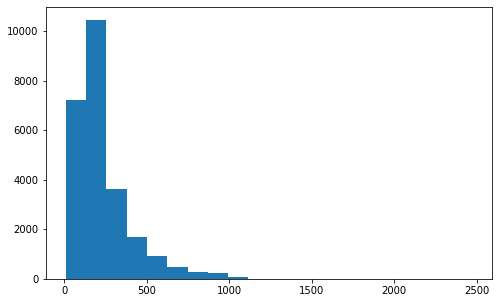

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8,5))
plt.hist(X_train_pd['word_count'], bins = 20)
plt.show()

In [78]:
# DISTRIBUTION OF word_count VARIABLE TO UNDERSTAND THE OPTIMAL LENGTH OF REVIEW
X_train_pd['word_count'].describe()

count    25000.000000
mean       233.776720
std        173.715418
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: word_count, dtype: float64

N_words = 175 seems like a good optimal choice for the review length


### Basic Text Preproessing

Entails 
1. Converting text to lower case, 
2. Removing punctuations/numeric fields, 
3. Addressing contrctions *(e.g. won't -> will not)* 

In [79]:
! pip install contractions
import contractions

In [0]:
# FUNCTION TO IMPLEMENT BASIC TEXT PREPROCESSING : LOWER-CASING & REMOVING NUMBERS/PUNCTUATION



def basic_preprocessor(text):
  
  import re
  import string
  import contractions

  # EXPANDING OUT CONTRACTIONS
  # e.g : don't -> do not
  text = contractions.fix(text)

  # TEXT TO LOWERCASE
  text = text.lower()
    
  # The syntax of re.sub() is:: re.sub(pattern, replace, source_string)
    
  # CODE TO HANDLE 's 
  # e.g: movie's -> movie s
  # THE HOPE IS THAT LSTMs SHOULD BE ABLE TO PROCESS THAT s 
  text = re.sub(r"(\w+)'s", r'\1 s', text)
  
  # HANDLING OTHER PUNCTUATION
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
    
  return text

In [0]:
# TESTING FUNCTION

X_train_pd['review_text_mod'] = X_train_pd.apply(lambda x: basic_preprocessor(x['review_text']),axis=1)

In [82]:
print(X_train_pd['review_text'][0])

print("\n")

print(X_train_pd['review_text_mod'][0])


b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."


bthis was an absolutely terrible movie do not be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie s ridiculous storyline this movie is an early nineties us p

Additionally, will remove stop-words if needed

In [83]:
# TEST SET
X_test_pd = pd.DataFrame(data = X_test, columns = ["review_text"])
X_test_pd['review_text_mod'] = X_test_pd.apply(lambda x: basic_preprocessor(x['review_text']),axis=1)


# CHECKING IF TE TRANSFORMATIONS WORKED OUT AS DESIGNED
print(X_test_pd['review_text'][0])
print("\n")
print(X_test_pd['review_text_mod'][0])

b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."


bthere are films that make careers for george romero it

In [0]:
# CREATING THE TEST AND TRAINING SETSSET
X_train_pd = X_train_pd[['review_text_mod']].copy()
X_test_pd = X_test_pd[['review_text_mod']].copy()

In [85]:
# EXAMINING BOTH THE TRAINING AND TEST SETS
X_train_pd.head()


,review_text_mod
0,bthis was an absolutely terrible movie do not ...
1,bi have been known to fall asleep during films...
2,bmann photographs the alberta rocky mountains ...
3,bthis is the kind of film for a snowy sunday a...
4,bas others have mentioned all the women that g...


In [0]:
# (OPTIONALLY) REMOVING STOPWORDS


# (OPTIONALLY) CORRECTING THAT b% AT THE BEGINNNING OF EACH SEQUENCE

## Tokenizing (and Padding) Text 


In [0]:
# SPECIFYING HYPERPARAMETERS

vocab_size = 10000
embedding_dim = 20
max_length = 175  
trunc_type = 'post'
oov_tok = "<OOV>"


In [0]:
# IMPPORTING LIBRARIES AND SETTING-UP TOKENIZER

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:
# IMPLEMENTING TOKENIZER

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)

tokenizer.fit_on_texts(X_train_pd['review_text_mod'])


In [90]:
# EXPLORING THE WORD-INDEX

word_index = tokenizer.word_index
print("length of the unfiltered vocabulary : ", len(word_index))

print("Type of object", type(word_index))



length of the unfiltered vocabulary :  137703
Type of object <class 'dict'>


In [91]:
# PADDING SEQUENCES - TRAINING SET

X_train_seq = tokenizer.texts_to_sequences(X_train_pd['review_text_mod'])

print("length of the first training sequence: ",len(X_train_seq[0])) # This is aligned with the length of the first sentence
      
X_train_pad = pad_sequences(X_train_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)

print("length of the first training sequence (PADDED): ",len(X_train_pad[0])) # Should be 175



length of the first training sequence:  120
length of the first training sequence (PADDED):  175


In [92]:
# TOKENIZATION AND PADDING ON TEST DATA

X_test_seq = tokenizer.texts_to_sequences(X_test_pd['review_text_mod'])

print("length of the first test sequence: ",len(X_test_seq[0])) # This is aligned with the length of the first sentence
      
X_test_pad = pad_sequences(X_test_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)

print("length of the first training sequence (PADDED): ",len(X_test_pad[0])) # Should be 175


length of the first test sequence:  163
length of the first training sequence (PADDED):  175


In [93]:
print(type(X_train_pad))
print(X_train_pad.shape)

print(type(y_train))
print(y_train.shape)

<class 'numpy.ndarray'>
(25000, 175)
<class 'numpy.ndarray'>
(25000,)


We now have the encoded and padded, training and test sets `X_train_pad` and `X_test_pad`.

<BR>

## LSTM Based Model

In [94]:
# DIVIDING THE TEST SET INTO VALIDATION AND TEST SETS

print(X_test_pad.shape)

X_val_pad = X_test_pad[0:12500]
X_test_pad = X_test_pad[12500:]

y_val = y_test[0:12500]
y_test = y_test[12500:]


(25000, 175)


In [104]:
# CLEAR BACKEND DATA

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


# CREATE AN LSTM BASED NEURAL NETWORK IN KERAS

#vocab_size = vocab_size   # NUMBER OF UNIQUE WORDS IN VOCAB = 10,000 
#embedding_dim = embedding_dim
sentence_length = max_length  # LENGTH OF EACH PADDED SENTENCE = 175


lstm_model = keras.models.Sequential([
                                          
                  keras.layers.Embedding(input_dim = vocab_size,
                                         output_dim = embedding_dim,
                                         input_length = sentence_length),
                          
                  keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences= True)),
                  #keras.layers.LayerNormalization(),
                  keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences = True)),
                  #keras.layers.LayerNormalization(),
                  keras.layers.Bidirectional(keras.layers.LSTM(32)),


                  #keras.layers.GlobalAveragePooling1D(),

                  keras.layers.Dense(128, activation = "relu"),
                  keras.layers.Dropout(rate = 0.1),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(64, activation = "relu"),
                  keras.layers.Dropout(rate = 0.1),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(1, activation = "sigmoid")
                  
])



# VIEW MODEL ARCHITECTURE
lstm_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 175, 20)           200000    
_________________________________________________________________
bidirectional (Bidirectional (None, 175, 256)          152576    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 175, 128)          164352    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

In [105]:
# QUICK CHECK ON DATA-TYPES AND SHAPES

print(type(X_train_pad),X_train_pad.shape )
print(type(y_train),y_train.shape)

print('\n')

print(type(X_test_pad),X_test_pad.shape )
print(type(y_test),y_test.shape)


<class 'numpy.ndarray'> (25000, 175)
<class 'numpy.ndarray'> (25000,)


<class 'numpy.ndarray'> (12500, 175)
<class 'numpy.ndarray'> (12500,)


In [106]:
# IMPLEMENT CALLBACKS

checkpoint_cb = keras.callbacks.ModelCheckpoint("imdb_lstm_best.h5",save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)




# COMPILE AND FIT MODEL

lstm_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['accuracy'])

history_1 = lstm_model.fit(X_train_pad,y_train, epochs = 20,
                            validation_data = (X_val_pad, y_val),
                            callbacks = [checkpoint_cb, early_stopping_cb]
                            
                            )

Epoch 1/20
782/782 [==============================] - 44s 56ms/step - loss: 0.5026 - accuracy: 0.7542 - val_loss: 0.7769 - val_accuracy: 0.8065
Epoch 2/20
782/782 [==============================] - 43s 55ms/step - loss: 0.4022 - accuracy: 0.8037 - val_loss: 1.6665 - val_accuracy: 0.4967
Epoch 3/20
782/782 [==============================] - 44s 57ms/step - loss: 0.4699 - accuracy: 0.7672 - val_loss: 0.6406 - val_accuracy: 0.7654
Epoch 4/20
782/782 [==============================] - 44s 56ms/step - loss: 0.2887 - accuracy: 0.8837 - val_loss: 0.3918 - val_accuracy: 0.8360
Epoch 5/20
782/782 [==============================] - 44s 56ms/step - loss: 0.2308 - accuracy: 0.9120 - val_loss: 0.4553 - val_accuracy: 0.8254
Epoch 6/20
782/782 [==============================] - 44s 56ms/step - loss: 0.1790 - accuracy: 0.9338 - val_loss: 0.6095 - val_accuracy: 0.8190
Epoch 7/20
782/782 [==============================] - 44s 56ms/step - loss: 0.1959 - accuracy: 0.9258 - val_loss: 0.5853 - val_accuracy:

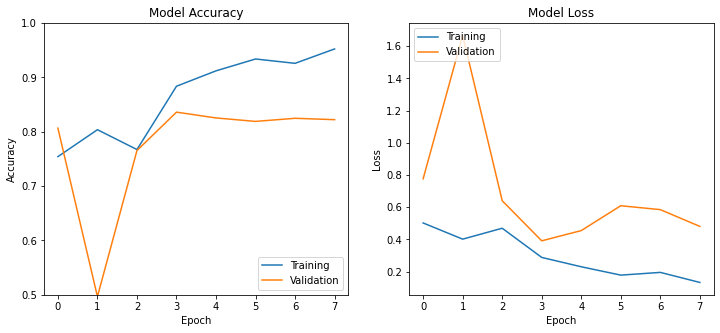

In [107]:
history = history_1


# BETTER LOOKING PLOTS FOR ACCURACY AND LOSS

import matplotlib.pyplot as plt

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_ylim([0.5,1])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Training', 'Validation'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Training', 'Validation'], loc='upper left')


In [108]:

# LOAD THE BEST PERFORMING MODEL (SO FAR.)
best_model = keras.models.load_model('imdb_lstm_best.h5')

best_model.evaluate(X_test_pad, y_test)

391/391 [==============================] - 7s 19ms/step - loss: 0.3938 - accuracy: 0.8372


[0.39382535219192505, 0.8371999859809875]